**Outlier detection with LSTM**

Motivation
My current client, wants to notify customers regarding anomolous acitvity from multiple ioT sensors 
(one the most important ones being temperature as it can indicate malfunctions)
Since there was no previous records, regarding anomalies an unsupervised approach was the obvious choice.
In this case LSTM.

My main insipiration on the subject:  https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46283.pdf

The original model was implemented in ' Azure Databricks' as an egg file (python package) with unit testing among other production standards. 
This is just for demonstration purposes (hence the lack of a proper folder structure), all data is public dataset and in any way represents current customer from Nuon.  

https://github.com/marciocourense
    

In [43]:
#%matplotlib notebook
import time
import sys
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import model_from_json
import time

 # Data Analysis and exploration

In [44]:
df = pd.read_csv("../temperature_anomaly_detection_dataset.csv")
df.head(5)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [45]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [46]:
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


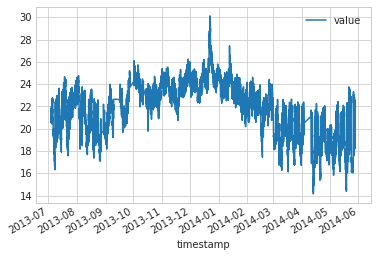

In [47]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

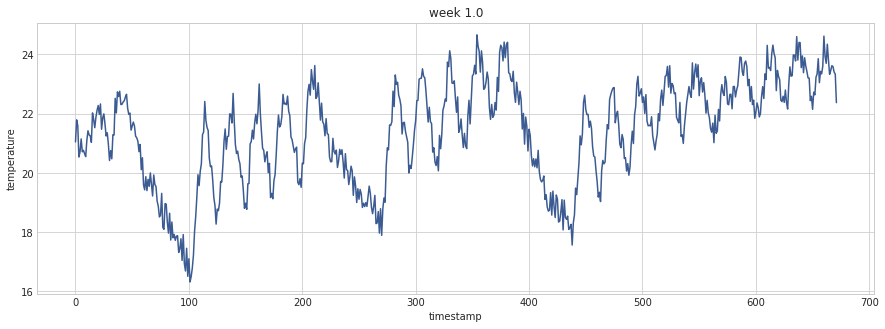

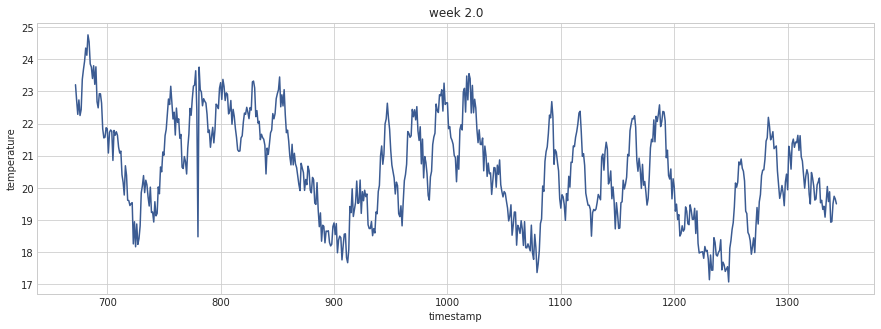

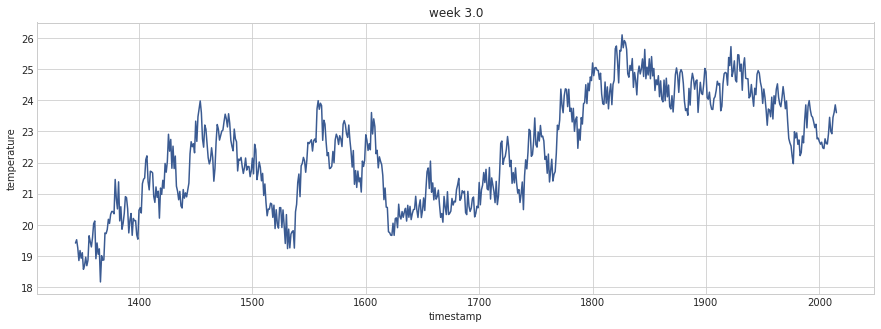

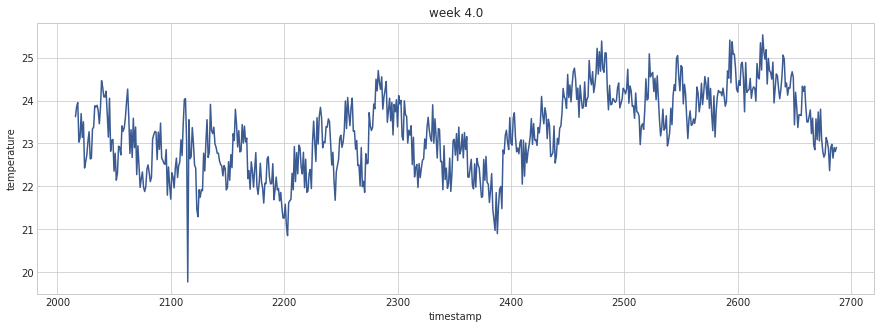

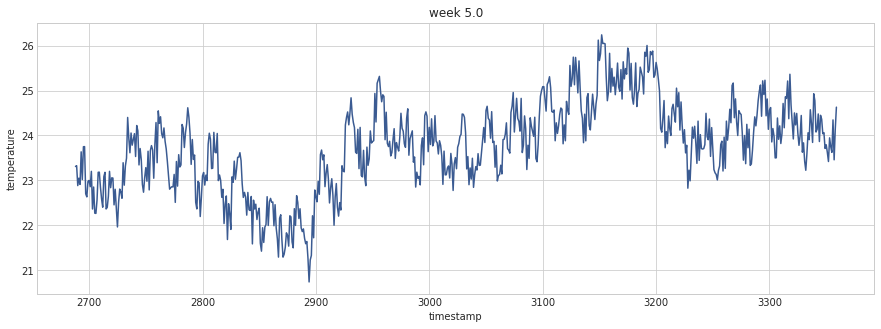

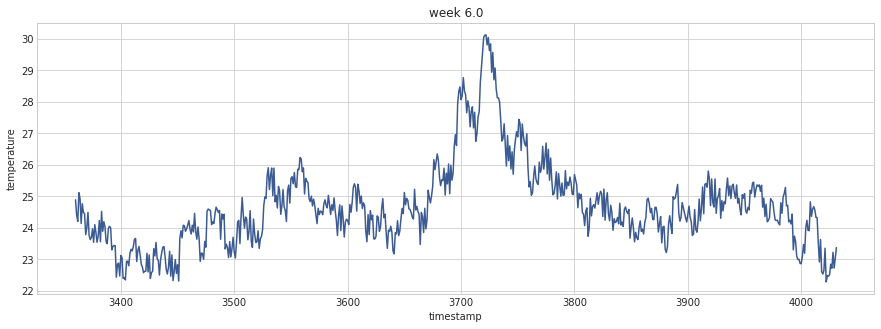

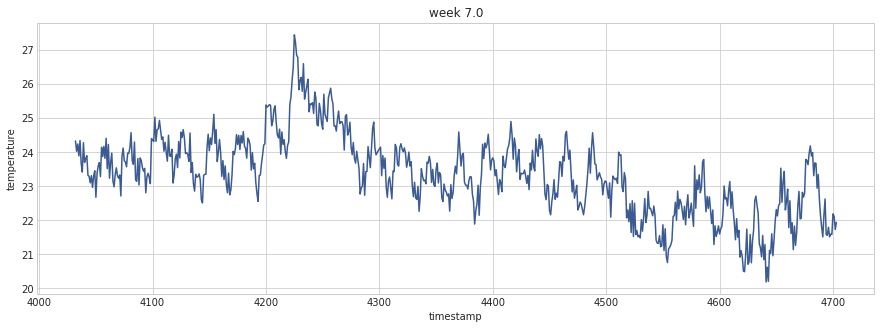

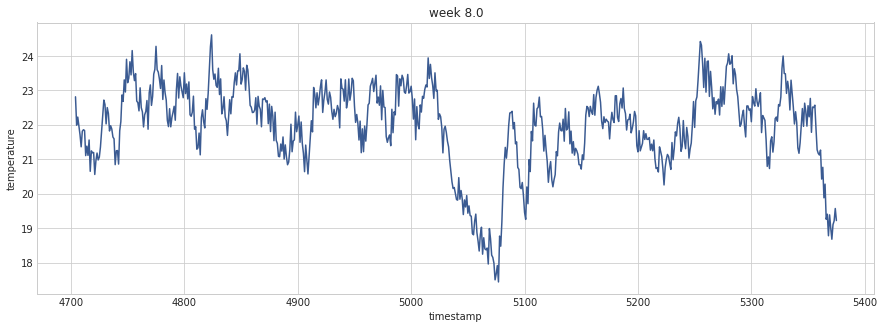

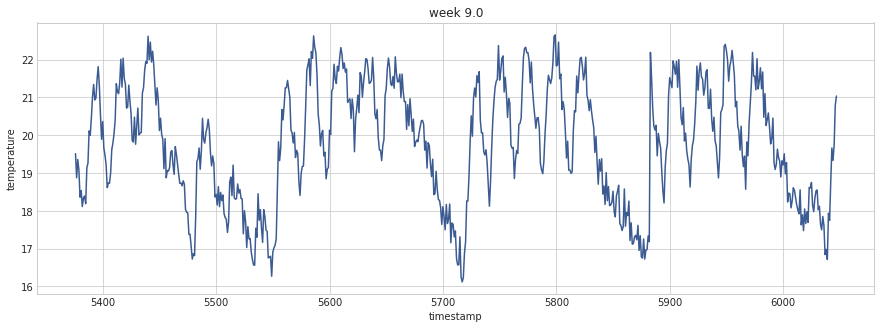

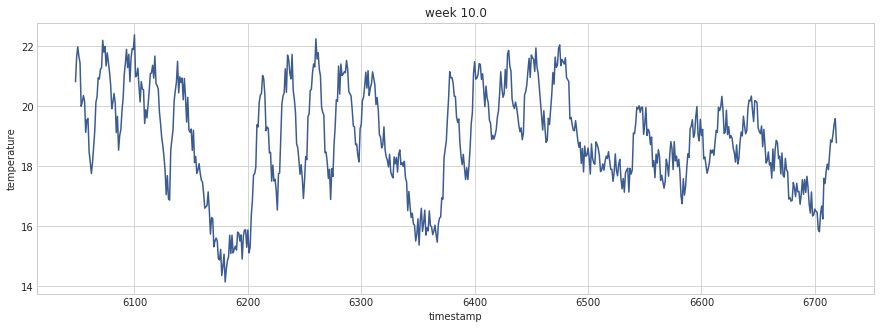

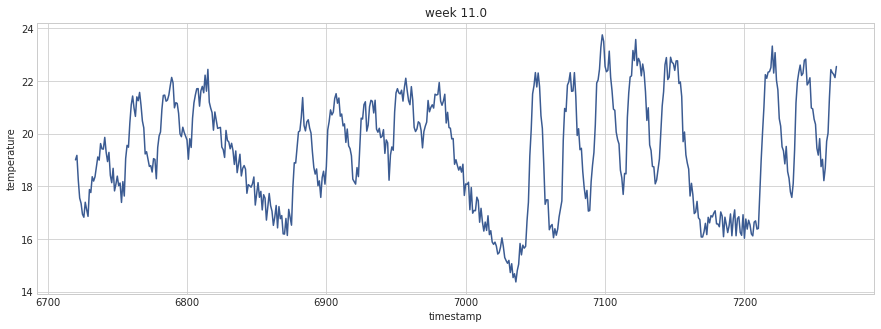

In [48]:
import seaborn as sns
sns.set_style("whitegrid")

#iterate over a week. a week will have 672 values
step = 672

#this will give weekly graphs
for i in range(0,df.shape[0],step):
    fig = plt.figure(figsize=(15,5))
    tmp = df[i:i+step]['value'].plot(color=sns.xkcd_rgb["denim blue"])
    plt.title("week %s"%(i/step +1))
    plt.xlabel('timestamp')
    plt.ylabel('temperature')
    plt.show()

### Feature engineering ###

In [49]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

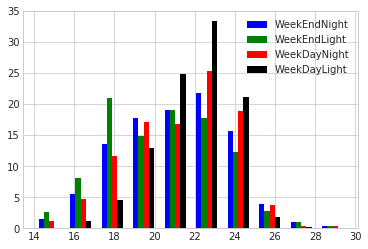

In [50]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

# fluctuations during night time

In [51]:

data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:616: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:459: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launche

In [52]:
#create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [53]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  import sys


compilation time : 0.024852752685546875


In [54]:
# Train the model
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 13s 2ms/step - loss: 0.6730 - val_loss: 0.8487
Epoch 2/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.2433 - val_loss: 0.4319
Epoch 3/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1458 - val_loss: 0.3428
Epoch 4/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1328 - val_loss: 0.2535
Epoch 5/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1029 - val_loss: 0.2151
Epoch 6/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1017 - val_loss: 0.1898
Epoch 7/30
5548/5548 [==============================] - 10s 2ms/step - loss: 0.1073 - val_loss: 0.1683
Epoch 8/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.0852 - val_loss: 0.1599
Epoch 9/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.0840 - val_loss: 0.1496
Epoch 10/30
5548/5548 [==========

In [55]:
# save the model because the training is long (1h30) and we don't want to do it every time
"""
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
"""

'\n# serialize model to JSON\nmodel_json = model.to_json()\nwith open("model2.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model2.h5")\nprint("Saved model to disk")\n'

In [56]:
# load json and create model
"""
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
"""

'\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n'

In [57]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

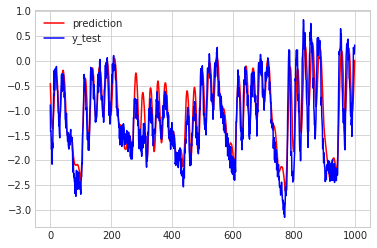

In [58]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [59]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


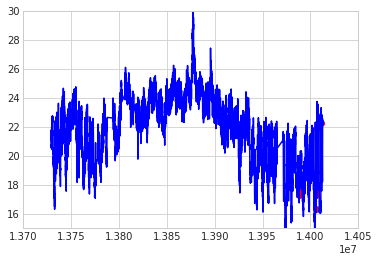

In [60]:
# visualisation of anomaly throughout time
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

# Improvements
LSTM potential for outlier detection is proven. However, this code & model are now being adpated
to Mxnet, which are more efficient than Tensorflow:
    https://www.quora.com/As-a-framework-do-you-recommend-Apache-MXNet-TensorFlow-Caffe-or-Caffe2
    https://www.oreilly.com/ideas/anomaly-detection-with-apache-mxnet (rather easy to implement)    